### Vector-Spread Gradient Descent Examples

We attempt to find the optimal spread of D unit vectors in a N-dimensional space using gradient descent.  A few different techniques are used, which illustrate the flexibility of Tensorflow to track gradients through complex computation sequences.

With these techniques, we are actually doing "gradient ascent", as we are trying to maximize the "spread" of all the vectors.  The concept is the same as gradient descent, and could actually be converted to a minimization problem just by multiplying spread by -1.

Here's the three techniques to try:
1. Maximizing the minimum-minimum angle -- The "loss" function returns the angle between the two vectors that are closest together.  Optimal spread should occur when this value is maximized.
2. Subtracting a variance term from the min-min solution -- Maximize the min-min angle as before, but simultaneously minimize the variance of minimum angles (create a list of angles, representing the angle of each vector to its closest neighbor, calculate the variance of that list).
3. Turn this into a semi-physics problem by computing a kind of reverse-gravitational force for all points on the unit-sphere.  Each node pushes other nodes away until at optimal dispersion, where all resulting forces should be zero

**Note:** All animated figures in this notebook are created using simple figure saving and `imagemagick` in Linux to create .gif files.  Native matplotlib animation code was implemented in the `using_plt_animation/vector_spread.ipynb` notebook, but it was found to be clunky and produce low-quality videos.  It is kept simply as a reference

In [57]:
import os
import shutil
import subprocess
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import IPython
from IPython.display import display, Image
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

print(f'Using Python  = {sys.version.split()[0]}')
print(f'Tensorflow    = {tf.__version__}')
print(f'Keras Version = {keras.__version__}')

# This disables using CUDA/GPU with tensorflow for this session
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Using Python  = 3.7.2
Tensorflow    = 2.1.0
Keras Version = 2.2.4-tf


In [115]:
class VectorSpreadAlgorithm:
    def __init__(self, n_vecs, n_dims=2, seed=None):
        self.n_vecs = n_vecs
        self.n_dims = n_dims
        self.spread_hist = []
        self.fig, self.ax = plt.subplots(figsize=(6,6))
    
        # This creates the initial set of vectors
        self.randomize_vecs(seed)
    
    
    def randomize_vecs(self, seed=None):
        if seed is None:
            seed = 84  # a value pre-determined to have a difficult initial state
        np.random.seed(seed)
        self.vecs = np.random.normal(size=(self.n_vecs, self.n_dims))
        self.norm_rows_inplace()
        
    
    def norm_rows_inplace(self):
        # 0.999 guarantees values < 1.0.  Values too close to 1.00 cause NaNs in tf.acos()
        self.vecs = 0.999 * keras.utils.normalize(self.vecs, axis=1)

    @staticmethod
    def calc_loss(tfvecs):
        raise NotImplementedError('This must be overridden in derived class')
        
    
    def plot_vecs(self, title=None, file_out=None, ax=None):
        if ax is None:
            fig, ax = self.fig, self.ax
            
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if title:
            ax.set_title(title)
            
        for i in range(self.n_vecs):
            vec = self.vecs[i, :]
            ax.plot([0, self.vecs[i,0]], [0, self.vecs[i,1]], 'b-', marker='o')
            
        ax.scatter([0], [0], s=100, c='red')
        
        if file_out:
            fig.savefig(file_out)
        
        return ax
        
    
    def one_iter(self, i, learning_rate, clip_norm=None):
        tfvecs = tf.convert_to_tensor(self.vecs, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(tfvecs)
            loss = self.calc_loss(tfvecs)

        ###############################################################################
        # Here's the magic!  Calculate gradients between computed spread and input vecs 
        gradients = tape.gradient(spread, tfvecs)
        ###############################################################################
        
        # For the final solution, we use force vectors but they can be massive when
        # vectors are really close.  We can clip them to prevent chaos.
        if clip_norm:
            gradients = tf.clip_by_norm(gradients, clip_norm)
            
        # Want to minimize loss so s
        self.vecs = self.vecs - learning_rate * gradients
        
        # Some standard book-keeping
        self.spread_hist.append(spread.numpy())
        self.norm_rows_inplace()
            
            
    def run_gradient_descent(self, n_iter, learning_rate=0.1, lr_decay=0.9, dir_out=None, clip_norm=None):
        shutil.rmtree(dir_out, ignore_errors=True)
        os.makedirs(dir_out, exist_ok=True)
        
        for i in range(n_iter + 1):
            self.one_iter(i, learning_rate)
            
            if i % 10 == 0:
                self.ax.clear()
                fout = os.path.join(dir_out, f'img_{i:05d}.png')
                self.plot_vecs(title=f'Iteration {i}/{n_iter}', file_out=fout)
            
            # After running at normal learning rate for a while, start decaying it
            if i > 0.6*n_iter and (i+1) % 50 == 0:
                learning_rate *= lr_decay
    
    
    def make_gif(self, dir_in, anim_out):
        try:
            subprocess.check_output(['convert', f'{dir_in}/*', '-loop', '0', '-delay', '50', anim_out])
        except subprocess.CalledProcessError as e:
            print(f'Error creating .gif, command returned exit code {e.returncode}')
            print(f'Command "{e.cmd}" returned output "{e.output}"')
    


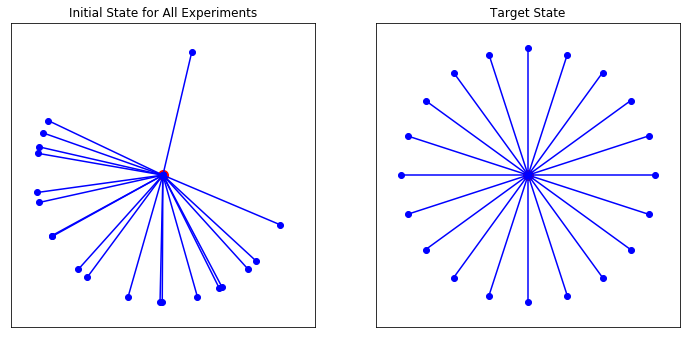

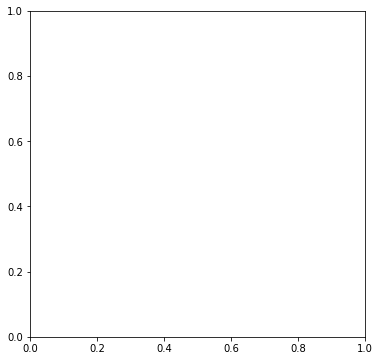

In [116]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
vs = VectorSpreadAlgorithm(20)
vs.plot_vecs(title='Initial State for All Experiments', ax=axs[0])
angles = np.arange(0, 2*np.pi, 2*np.pi/20)
solution_mtrx = np.zeros(shape=(20, 2))
solution_mtrx[:,0] = np.array([np.cos(a) for a in angles])
solution_mtrx[:,1] = np.array([np.sin(a) for a in angles])
vs.vecs = solution_mtrx
_ = vs.plot_vecs(title='Target State', ax=axs[1])

In [106]:
class VectorSpread_MaxMinAngle(VectorSpreadAlgorithm):
    @staticmethod
    def calc_loss(tensor2d):
        """
        This method should use tf.* methods to compute a quantity to maximize
        Assumes all rows already normalized
        """
        angle_pairs = tf.acos(tensor2d @ tf.transpose(tensor2d))
        disable_diag = tf.eye(tensor2d.numpy().shape[0]) * 2 * np.pi
        spread_metric = tf.reduce_min(angle_pairs + disable_diag)    
        
        # Convention is to return a quantity to be minimized, but we want
        # to maximize spread.  So return neg spread to make it a min-problem
        return -spread_metric  
    

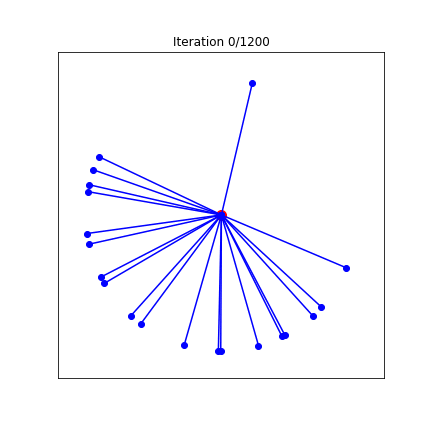

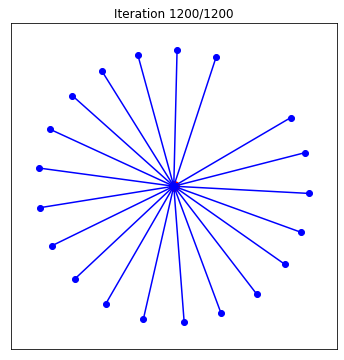

In [46]:
name = 'solution_0_maxmin_angle'
vs = VectorSpread_MaxMinAngle(20)
vs.run_gradient_descent(n_iter=1200, learning_rate=0.05, dir_out=name)
vs.make_gif(name, f'{name}.gif')
Image(f'{name}.gif')

-----

-----

In [47]:
class VectorSpread_MaxMinAngle_with_Variance(VectorSpreadAlgorithm):
    def calc_loss(self, tensor2d):
        """ Assumes all rows already normalized """
        angle_pairs = tf.acos(tensor2d @ tf.transpose(tensor2d))
        disable_diag = tf.eye(tensor2d.numpy().shape[0]) * 2 * np.pi
        all_mins = tf.reduce_min(angle_pairs + disable_diag, axis=1)    
        
        # We want to maximize the min-min angle, as before
        min_min = tf.reduce_min(all_mins)
        
        # Additionally subtract the variance of the set of minimum angles.  Our target
        # configuration should have all vectors with the same minimum-angle neighbor.
        avg_min = tf.reduce_mean(all_mins)
        var_min = tf.reduce_sum(tf.square(all_mins - avg_min))
        
        # Don't give variance term equal weighting, but it shoudl be included
        coef_min = 1.0
        coef_var = 0.4
        spread_metric = coef_min * min_min - coef_var * var_min
        
        # Again, conv
        return -spread_metric

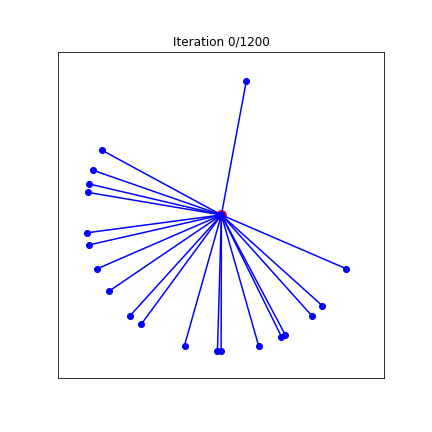

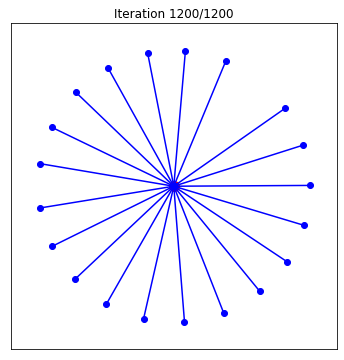

In [48]:
name = 'solution_1_maxmin_w_var'
vs = VectorSpread_MaxMinAngle_with_Variance(20)
vs.run_gradient_descent(n_iter=1200, learning_rate=0.05, dir_out=name)
vs.make_gif(name, f'{name}.gif')
Image(f'{name}.gif')

In [ ]:
    n_vec = tensor2d.numpy().shape[0]
    all_force_list = []
    for this_idx in range(n_vec):

        # Accumulate force of all other vecs onto this one
        this_force_list = []

        for other_idx in range(n_vec):

            if this_idx == other_idx:
                continue

            this_vec = tensor2d[this_idx, :]
            other_vec = tensor2d[other_idx, :]

            tangent_force_vec = self.force_a_onto_b(other_vec, this_vec)
            this_force_list.append(tangent_force_vec)

        # We now have a list of all N-dimensional force vecs.  Stack and sum
        sum_tangent_forces = tf.reduce_sum(tf.stack(this_force_list))
        this_force_magnitude = tf.sqrt(tf.reduce_sum(sum_tangent_forces**2))

        # Accumulate all magnitudes, which should all be zero at optimal solution
        all_force_list.append(this_force_magnitude)

    # More force = less spread, so change sign (so it's still a maximization problem)
    to_maximize = -tf.reduce_sum(tf.stack(all_force_list))
    return to_maximize


-----

-----

In [89]:
class VectorSpread_Force(VectorSpreadAlgorithm):
    
    def calc_force_a_onto_b(self, vec_a, vec_b):
        diff = vec_b - vec_a
        norm = tf.sqrt(tf.reduce_sum(diff**2))
        force_vec = diff / norm**3

        # Project force vector onto this vec, calculate how much is radial
        b_dot_f = tf.tensordot(vec_b, force_vec, axes=1)
        b_dot_b = tf.tensordot(vec_b, vec_b, axes=1)
        radial_component =  (b_dot_f / b_dot_b) * vec_b

        # Subtract radial component, calculate resulting magnitude
        return force_vec - radial_component
            
    
    def calc_loss(self, tensor2d):
        """ Assumes all rows already normalized """
        n_vec = tensor2d.numpy().shape[0]
        
        all_force_list = []
        for this_idx in range(n_vec):
            
            # Accumulate force contribution of all other vecs onto this one
            this_force_list = []
            
            for other_idx in range(n_vec):
                
                if this_idx == other_idx:
                    continue

                this_vec = tensor2d[this_idx, :]
                other_vec = tensor2d[other_idx, :]
                
                tangent_force_vec = self.calc_force_a_onto_b(other_vec, this_vec)
                this_force_list.append(tangent_force_vec)
            
            # We now have a list of all N-dimensional force vecs.  Stack and sum
            sum_tangent_forces = tf.reduce_sum(tf.stack(this_force_list))
            this_force_magnitude = tf.sqrt(tf.reduce_sum(sum_tangent_forces**2))
            
            # Accumulate all magnitudes, which should all be zero at optimal solution
            all_force_list.append(this_force_magnitude)
            
        net_force_sum = tf.reduce_sum(tf.stack(all_force_list))
        
        # No negative needed -- force sum should be minimized for optimal solution
        return net_force_sum
    


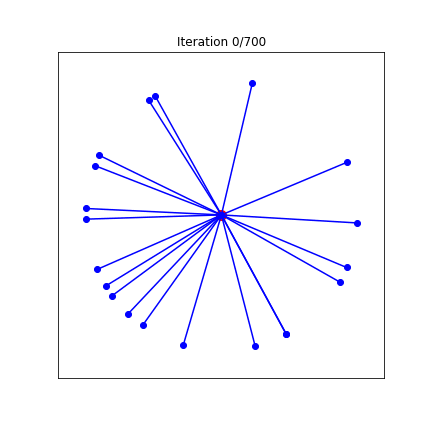

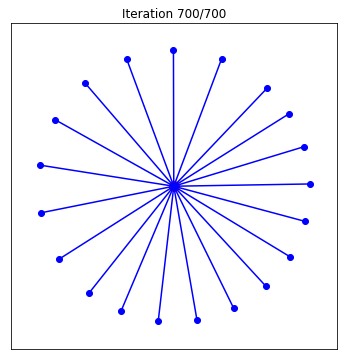

In [113]:
name = 'solution_2_minimize_force'
vs = VectorSpread_Force(20)
vs.run_gradient_descent(n_iter=700, learning_rate=3e-5, lr_decay=0.8, dir_out=name)
vs.make_gif(name, f'{name}.gif')
Image(f'{name}.gif')

-----

-----

### Upload the .gif files to make sure they are up to date for the blog post

I could look really smart and use boto3 library, but it seems like overkill.  AWSCLI commands are appropriate here.

In [114]:
!aws s3 cp solution_0_maxmin_angle.gif   s3://areiner-toptal-blog-resources/vector_spread/ --acl public-read
!aws s3 cp solution_1_maxmin_w_var.gif   s3://areiner-toptal-blog-resources/vector_spread/ --acl public-read
!aws s3 cp solution_2_minimize_force.gif s3://areiner-toptal-blog-resources/vector_spread/ --acl public-read


upload: ./solution_0_maxmin_angle.gif to s3://areiner-toptal-blog-resources/vector_spread/solution_0_maxmin_angle.gif
upload: ./solution_1_maxmin_w_var.gif to s3://areiner-toptal-blog-resources/vector_spread/solution_1_maxmin_w_var.gif
upload: ./solution_2_minimize_force.gif to s3://areiner-toptal-blog-resources/vector_spread/solution_2_minimize_force.gif
